In [118]:
import numpy as np
import matplotlib.pyplot as plt
import theano
import theano.tensor as T
%matplotlib inline

In [119]:
import lasagne
from lasagne.layers import *

In [120]:
input_D=T.tensor3("Discriminator")
input_G=T.tensor3("Generator")

In [121]:
N=150
input_shape=[100,N,2]


In [122]:
gl1=InputLayer(shape=[100,1,1],input_var=input_G)
gl2=DenseLayer(gl1,num_units=N*20,nonlinearity=lasagne.nonlinearities.rectify)
gl3=DenseLayer(gl2,num_units=N*8,nonlinearity=lasagne.nonlinearities.rectify)
gl_out=DenseLayer(gl3,num_units=N*2,nonlinearity=lasagne.nonlinearities.linear)

y_g_pred=lasagne.layers.get_output(gl_out)

weights_g=lasagne.layers.get_all_params(gl_out)


In [123]:
dl1T=InputLayer(shape=input_shape,input_var=input_D)
dl2T=DenseLayer(dl1T,num_units=N,nonlinearity=lasagne.nonlinearities.elu)
dl3T=DenseLayer(dl2T,num_units=10,nonlinearity=lasagne.nonlinearities.sigmoid)
dlT_out=DenseLayer(dl3T,num_units=1,nonlinearity=lasagne.nonlinearities.sigmoid)

dlg_input=y_g_pred.reshape(shape=input_shape)

dl1G=InputLayer(shape=input_shape,input_var=dlg_input)
dl2G=DenseLayer(dl1G,num_units=N,nonlinearity=lasagne.nonlinearities.elu,W=dl2T.W,b=dl2T.b)
dl3G=DenseLayer(dl2G,num_units=10,nonlinearity=lasagne.nonlinearities.sigmoid,W=dl3T.W,b=dl3T.b)
dlG_out=DenseLayer(dl3G,num_units=1,nonlinearity=lasagne.nonlinearities.sigmoid,W=dlT_out.W,b=dlT_out.b)

y_dG_pred=lasagne.layers.get_output(dlG_out)
y_dT_pred=lasagne.layers.get_output(dlT_out)


weights_d=lasagne.layers.get_all_params(dlT_out)

In [124]:
loss_d=-(T.log(y_dT_pred+1e-9)+T.log(1-y_dG_pred+1e-9)).mean()
accuracy_d=((y_dT_pred>0.5).sum()+(y_dG_pred<0.5).sum())/(y_dG_pred.shape[0]+y_dT_pred.shape[0])

updates_sgd_d=lasagne.updates.adadelta(loss_d,weights_d,learning_rate=0.3)
#D_lr = theano.shared(np.array(0.01, dtype=theano.config.floatX))
#updates_sgd_d = lasagne.updates.nesterov_momentum(loss_d, weights_d, learning_rate=D_lr, momentum=0.6)
    
train_fun_d=theano.function([input_D,input_G],[loss_d,accuracy_d],updates=updates_sgd_d)

accuracy_fun_d=theano.function([input_D,input_G],accuracy_d)

loss_g=-(T.log(y_dG_pred+1e-9)).mean()

accuracy_g=(y_dG_pred>0.5).sum()/(y_dG_pred.shape[0])
updates_sgd_g=lasagne.updates.adadelta(loss_g,weights_g,learning_rate=0.3)
#G_lr = theano.shared(np.array(0.01, dtype=theano.config.floatX))
#updates_sgd_g = lasagne.updates.nesterov_momentum(loss_g, weights_g, learning_rate=G_lr, momentum=0.6)
    
train_fun_g=theano.function([input_G],[loss_g,accuracy_g],updates=updates_sgd_g)
accuracy_fun_g=theano.function([input_G],accuracy_g)

In [125]:
def make_normal(center,mu,sz):
    mu+=(np.random.random()-0.5)*0.02
    center+=(np.random.random()-0.5)*0.2
    return np.random.normal(center,mu,size=sz)

In [128]:
def make_noise(sz):
    return (np.linspace(-5.0,5.0,sz[0])+np.random.random(sz[0])*0.01).reshape(sz)
    return np.random.random(size=sz)

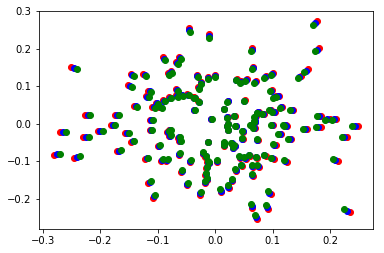

In [129]:
p=y_g_pred.eval({input_G:make_noise([100,1,1])}).reshape(input_shape)
plt.plot([i[0] for i in p[0]],[i[1] for i in p[0]],'ro')
plt.plot([i[0] for i in p[1]],[i[1] for i in p[1]],'bo')
plt.plot([i[0] for i in p[2]],[i[1] for i in p[2]],'go')
plt.show()

In [130]:
center=5
mu=1

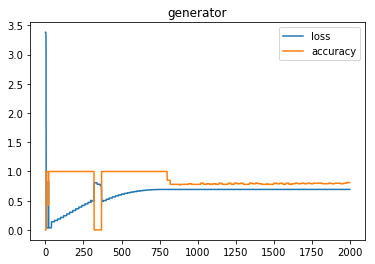

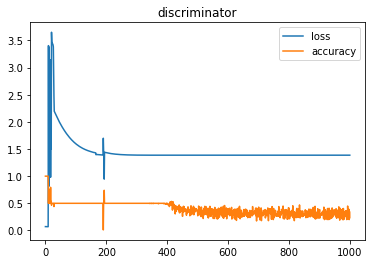

In [141]:
num_ep=100
losses=[]
accuracies=[]
losses1=[]
accuracies1=[]
for i in range(num_ep):
    for k in range(10):
        inptD=make_normal(center,mu,sz=[100,N,2])
        input_noiseG=make_noise(sz=[100,1,1])
        loss1,accuracy1=train_fun_d(inptD,input_noiseG)

        losses1.append(loss1)
        accuracies1.append(accuracy1)
    for k in range(20):
        loss,accuracy=train_fun_g(input_noiseG)
        losses.append(loss)
        accuracies.append(accuracy)

plt.title('generator')
plt.plot(losses,label="loss")
plt.plot(accuracies,label='accuracy')
plt.legend()
plt.show()
plt.title('discriminator')
plt.plot(losses1,label="loss")
plt.plot(accuracies1,label='accuracy')
plt.legend()
plt.show()

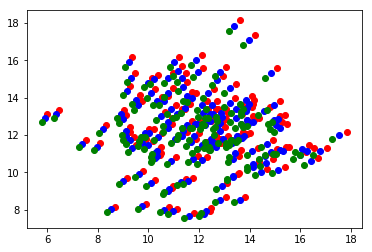

In [142]:
p=y_g_pred.eval({input_G:make_noise([100,1,1])}).reshape(input_shape)
plt.plot([i[0] for i in p[0]],[i[1] for i in p[0]],'ro')
plt.plot([i[0] for i in p[1]],[i[1] for i in p[1]],'bo')
plt.plot([i[0] for i in p[2]],[i[1] for i in p[2]],'go')
plt.show()

In [143]:
#print(y_dT_pred.eval({input_D:make_noise(sz=[100,N,2])})[0])
print(y_dT_pred.eval({input_D:make_normal(5,1,sz=[100,N,2])})[0])
print(y_dG_pred.eval({input_G:make_noise(sz=[100,1,1])})[0])
print(accuracy_fun_d(make_normal(5,1,sz=[100,N,2]),make_noise(sz=[100,1,1])))
print(accuracy_fun_d(make_normal(15,1,sz=[100,N,2]),make_noise(sz=[100,1,1])))
#print(accuracy_fun_d(make_noise(sz=[100,N,2]),make_noise(sz=[100,1,1])))
#print(accuracy_fun_d(make_noise(sz=[100,N,2]),make_noise(sz=[100,1,1])))


[ 0.49999894]
[ 0.5000009]
0.395
0.595


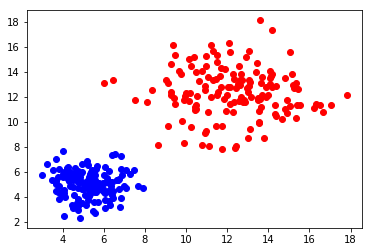

In [145]:
p=y_g_pred.eval({input_G:make_noise([100,1,1])}).reshape([100,N,2])
p1=make_normal(5,1,[1,N,2])
plt.plot([i[0] for i in p[0]],[i[1] for i in p[0]],'ro')
plt.plot([i[0] for i in p1[0]],[i[1] for i in p1[0]],'bo')

In [146]:
y_dT_pred.eval({input_D:p})

array([[ 0.5000009 ],
       [ 0.5000009 ],
       [ 0.5000009 ],
       [ 0.5000009 ],
       [ 0.5000009 ],
       [ 0.5000009 ],
       [ 0.5000009 ],
       [ 0.5000009 ],
       [ 0.5000009 ],
       [ 0.5000009 ],
       [ 0.5000009 ],
       [ 0.5000009 ],
       [ 0.5000009 ],
       [ 0.5000009 ],
       [ 0.5000009 ],
       [ 0.5000009 ],
       [ 0.5000009 ],
       [ 0.5000009 ],
       [ 0.5000009 ],
       [ 0.5000009 ],
       [ 0.5000009 ],
       [ 0.5000009 ],
       [ 0.5000009 ],
       [ 0.5000009 ],
       [ 0.5000009 ],
       [ 0.5000009 ],
       [ 0.5000009 ],
       [ 0.5000009 ],
       [ 0.5000009 ],
       [ 0.5000009 ],
       [ 0.50000089],
       [ 0.50000089],
       [ 0.50000088],
       [ 0.50000086],
       [ 0.50000084],
       [ 0.50000081],
       [ 0.50000075],
       [ 0.50000065],
       [ 0.5000005 ],
       [ 0.5000003 ],
       [ 0.50000006],
       [ 0.49999982],
       [ 0.49999962],
       [ 0.49999945],
       [ 0.49999932],
       [ 0